## VAE Network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim):
        super().__init__()

#         self.input = nn.Linear(input_dim + label_dim, hidden_dim)
        self.input = nn.Linear(input_dim, hidden_dim)
#         self.bn = nn.BatchNorm1d(hidden_dim)
        
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.5)
        
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(0.5)
        
        self.mu_z = nn.Linear(hidden_dim, latent_dim)
        self.std_z = nn.Linear(hidden_dim, latent_dim)

#     def forward(self, x, label):
    def forward(self, x):
#         out = self.input(torch.cat((x, label), -1))
        out = self.input(x)
#         out = self.bn(out)
        out = F.relu(out)
        out = self.hidden(out)
        out = self.bn1(out)
        out = self.dropout1(out)
        
        out = F.relu(out)
        out = self.hidden2(out)
        out = self.bn2(out)
        out = self.dropout2(out)
        
        out = F.relu(out)
        mu_z = self.mu_z(out)
        std_z = self.std_z(out)

        return mu_z, std_z


class Decoder(nn.Module):
    def __init__(self, latent_dim, label_dim, hidden_dim, output_dim):
        super().__init__()

#         self.input = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.input = nn.Linear(latent_dim, hidden_dim)
#         self.bn = nn.BatchNorm1d(hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.5)
        
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(0.5)
        
        self.mu_x = nn.Linear(hidden_dim, output_dim)
        self.std_x = nn.Linear(hidden_dim, output_dim)

#     def forward(self, z, label):
    def forward(self, z):
#         out = self.input(torch.cat((z, label), -1))
        out = self.input(z)
#         out = self.bn(out)
        out = F.relu(out)
        out = self.hidden(out)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.dropout1(out)
        
        out = self.hidden2(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.dropout2(out)
        
        mu_x = self.mu_x(out)
        std_x = self.std_x(out)

        return mu_x, std_x

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import torch 
import pandas as pd 
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

In [3]:
bos = load_boston()
df = pd.DataFrame(bos.data)
df.columns = bos.feature_names
print(len(bos.feature_names))
df["Price"] = bos.target

data = df[df.columns[:-1]]
# data = data.apply(
#     lambda x: (x - x.mean()) / x.std()
# )

data["Price"] = df.Price

13


In [4]:
from sklearn import preprocessing

# Dataset to numpy
X = torch.tensor(data.drop("Price", axis=1).values).type(torch.float64)
Y = torch.tensor(data["Price"].values).type(torch.float64)

# Split dataset for test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,
                                                    random_state=42)

# Standardize 
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)

Y_train = Y_train.view(-1, 1)
Y_test = Y_test.view(-1, 1)

In [5]:
def loss_fn(mu_z, std_z, z_sample, mu_x, std_x, x_in):
    S = x_in.shape[0]
    
    # log posterior q(z|x)
    q_z_dist = torch.distributions.Normal(mu_z, torch.exp(std_z))
    log_q_z = q_z_dist.log_prob(z_sample)
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x_in)
    
    # log prior 
    p_z_dist = torch.distributions.Normal(0, 1)
    log_p_z = p_z_dist.log_prob(z_sample)
    
    loss = (1 / S) * (
        torch.sum(log_q_z) - torch.sum(log_p_x) - torch.sum(log_p_z) 
    )
    
    return loss

In [6]:
""" Hyperparameters """
N_EPOCHS = 50     # N_EPOCHS = 100 overfitted the data so the evaluation was very bad 
BATCH_SIZE = 128
lr = 0.005
INPUT_DIM = X_train.shape[1]
LABEL_DIM = Y_train.shape[1]
LATENT_DIM = 2
HIDDEN_DIM = 6

In [7]:
train_data = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)

In [8]:
encoder = Encoder(INPUT_DIM, LABEL_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)
decoder = Decoder(LATENT_DIM, LABEL_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

In [9]:
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, weight_decay=1e-3)

In [10]:
train_loss_avg = []


for ep in range(N_EPOCHS):
    train_loss_avg.append(0)
    num_batches = 0
    
    for x, y in train_iter:
        # Update the gradient to zero 
        optimizer.zero_grad()
        
        # Forward pass 
        # Encoder
#         mu_z, std_z = encoder(x, y)
        mu_z, std_z = encoder(x)

        # Sample z
        eps = torch.randn_like(std_z)
        z_samples = mu_z + eps * torch.exp(std_z)

        # Decoder
#         mu_x, std_x = decoder(z_samples, y)
        mu_x, std_x = decoder(z_samples)
        eps = torch.randn_like(std_x)

#         x_samples = mu_x + eps * torch.exp(std_x)

#         return mu_z, std_z, z_samples, mu_x, std_x, x_samples
        
        # Loss 
        loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, x)
        
        # Backward pass 
        loss.backward()
        
        # Update the weights 
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    
    train_loss_avg[-1] /= num_batches
    print("Epoch [%d / %d] average loss: %f" % (ep+1, N_EPOCHS, train_loss_avg[-1]))

Epoch [1 / 50] average loss: 1026.744278
Epoch [2 / 50] average loss: 35.010728
Epoch [3 / 50] average loss: 112.939371
Epoch [4 / 50] average loss: 40.590947
Epoch [5 / 50] average loss: 25.575437
Epoch [6 / 50] average loss: 43.748238
Epoch [7 / 50] average loss: 30.860400
Epoch [8 / 50] average loss: 32.246293
Epoch [9 / 50] average loss: 23.829147
Epoch [10 / 50] average loss: 24.461396
Epoch [11 / 50] average loss: 1987.802036
Epoch [12 / 50] average loss: 34669.845249
Epoch [13 / 50] average loss: 22.306560
Epoch [14 / 50] average loss: 23.931595
Epoch [15 / 50] average loss: 23.401250
Epoch [16 / 50] average loss: 25.915530
Epoch [17 / 50] average loss: 22.461560
Epoch [18 / 50] average loss: 24.432224
Epoch [19 / 50] average loss: 23.056782
Epoch [20 / 50] average loss: 23.273985
Epoch [21 / 50] average loss: 22.190713
Epoch [22 / 50] average loss: 24.851242
Epoch [23 / 50] average loss: 22.554599
Epoch [24 / 50] average loss: 22.909927
Epoch [25 / 50] average loss: 22.850894
E

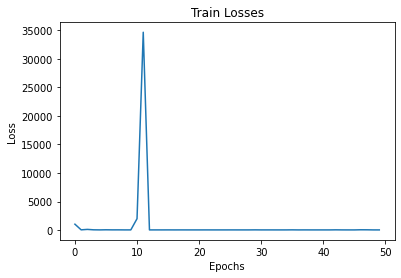

In [11]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.title("Train Losses")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Loss function 
$$
\log p(x_i) \geq \int q_\theta(z|x_i) [\log p_\phi(x_i|z) + \log p(z) - \log q_\theta(z|x_i)] dz\\
\approx - \frac{1}{S} \sum_{i=1}^{S} [\log q_\theta(z|x_i) - \log p_\phi(x_i|z) - \log p(z)]\\
= -\frac{1}{S} \sum_{i=1}^S [\mathcal{N}(z|\mu(x_i), \sigma(x_i))- \mathcal{N}(x_i|\mu(z), \sigma(z)) - \mathcal{N}(z|0, 1)]
$$
We add a negative sign to the loss function because the lower bound should be maximized while the loss function should be minimized.

### Test evaluation metrics
$$
\log p(x_i) \geq \int q_\theta(z|x_i) [\log p_\phi(x_i|z) + \log p(z) - \log q_\theta(z|x_i)] dz\\
\approx - \frac{1}{S} \sum_{i=1}^{S} [\log p_\phi(x_i|z)]\\
$$


Should I set $q_\theta(z|x_i)$ to $\mathcal{N}(z|0,1)$ if I am testing with $z\sim q(z)$? So the test evaluation would just be on the term $\log p_\phi(x_i|z)$.
I will be using my trained cVAE for predicting $x$ given just the label. It make sense to test in an environment same as how I will be using the model. So I should just find the error caused by the decoder. 

Referenced for loss function:
https://medium.com/retina-ai-health-inc/variational-inference-derivation-of-the-variational-autoencoder-vae-loss-function-a-true-story-3543a3dc67ee

Tutorial referenced:
https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb#scrollTo=LKnr0LCMhEGj

In [12]:
test_data = torch.utils.data.TensorDataset(X_test, Y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [13]:
def eval_metrics(mu_x, std_x, x_in):
    S = x_in.shape[0]
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x_in)
    
    loss = - (1 / S) * (torch.sum(log_p_x))
    
    return loss 

Sampling

In [14]:
S = 1000
# # Forward pass 
p_z_given_x = torch.distributions.Normal(0, 1)
z = p_z_given_x.sample((S, LATENT_DIM)).type(torch.float64)
# mu_x, std_x = decoder(z, Y_test)   
mu_x, std_x = decoder(z)

In [15]:
eps = torch.distributions.Normal(0, 1).sample(std_x.shape)
x_samples = mu_x + std_x * eps

In [16]:
x_samples.mean(0)

tensor([ 0.0044,  0.1345,  0.2218, -0.1924,  0.1863, -0.1386, -0.0082,  0.2063,
         0.0074,  0.0162, -0.2875,  0.0086,  0.2805], dtype=torch.float64,
       grad_fn=<MeanBackward1>)

In [17]:
X_test.mean(0)

tensor([ 0.0576, -0.0059,  0.0018, -0.0546, -0.0732, -0.1902, -0.0271,  0.0457,
         0.0430,  0.0239,  0.2623, -0.1161,  0.1087], dtype=torch.float64)

In [18]:
std_x.mean(0)

tensor([-0.0617,  0.2984,  0.2411,  0.2331,  0.1735,  0.1998,  0.0312, -0.1382,
         0.0158,  0.0019, -0.1407,  0.0043,  0.1077], dtype=torch.float64,
       grad_fn=<MeanBackward1>)

In [19]:
x_samples.std(0)

tensor([0.0872, 0.5548, 0.4167, 0.4909, 0.3222, 0.3776, 0.1203, 0.3838, 0.1612,
        0.0856, 0.5930, 0.0926, 0.4084], dtype=torch.float64,
       grad_fn=<StdBackward1>)

In [20]:
X_test.std(0)

tensor([1.1143, 1.1066, 0.9665, 0.9077, 0.9764, 0.9116, 1.0617, 0.9717, 1.0299,
        1.0444, 0.8328, 1.1600, 1.0140], dtype=torch.float64)

Text(0, 0.5, 'Mean of Generated Distribution')

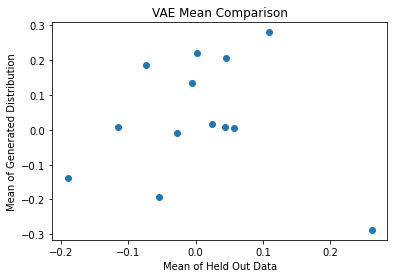

In [21]:
plt.scatter(X_test.mean(0).detach().numpy(), x_samples.mean(0).detach().numpy())
plt.title("VAE Mean Comparison")
plt.xlabel("Mean of Held Out Data")
plt.ylabel("Mean of Generated Distribution")

Text(0, 0.5, 'Standard Deviation of Generated Distribution')

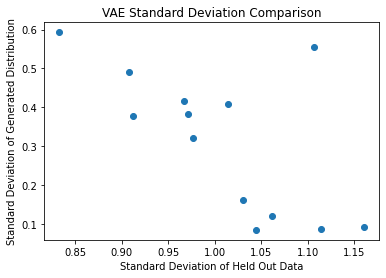

In [22]:
plt.scatter(X_test.std(0).detach().numpy(), x_samples.std(0).detach().numpy())
plt.title("VAE Standard Deviation Comparison")
plt.xlabel("Standard Deviation of Held Out Data")
plt.ylabel("Standard Deviation of Generated Distribution")

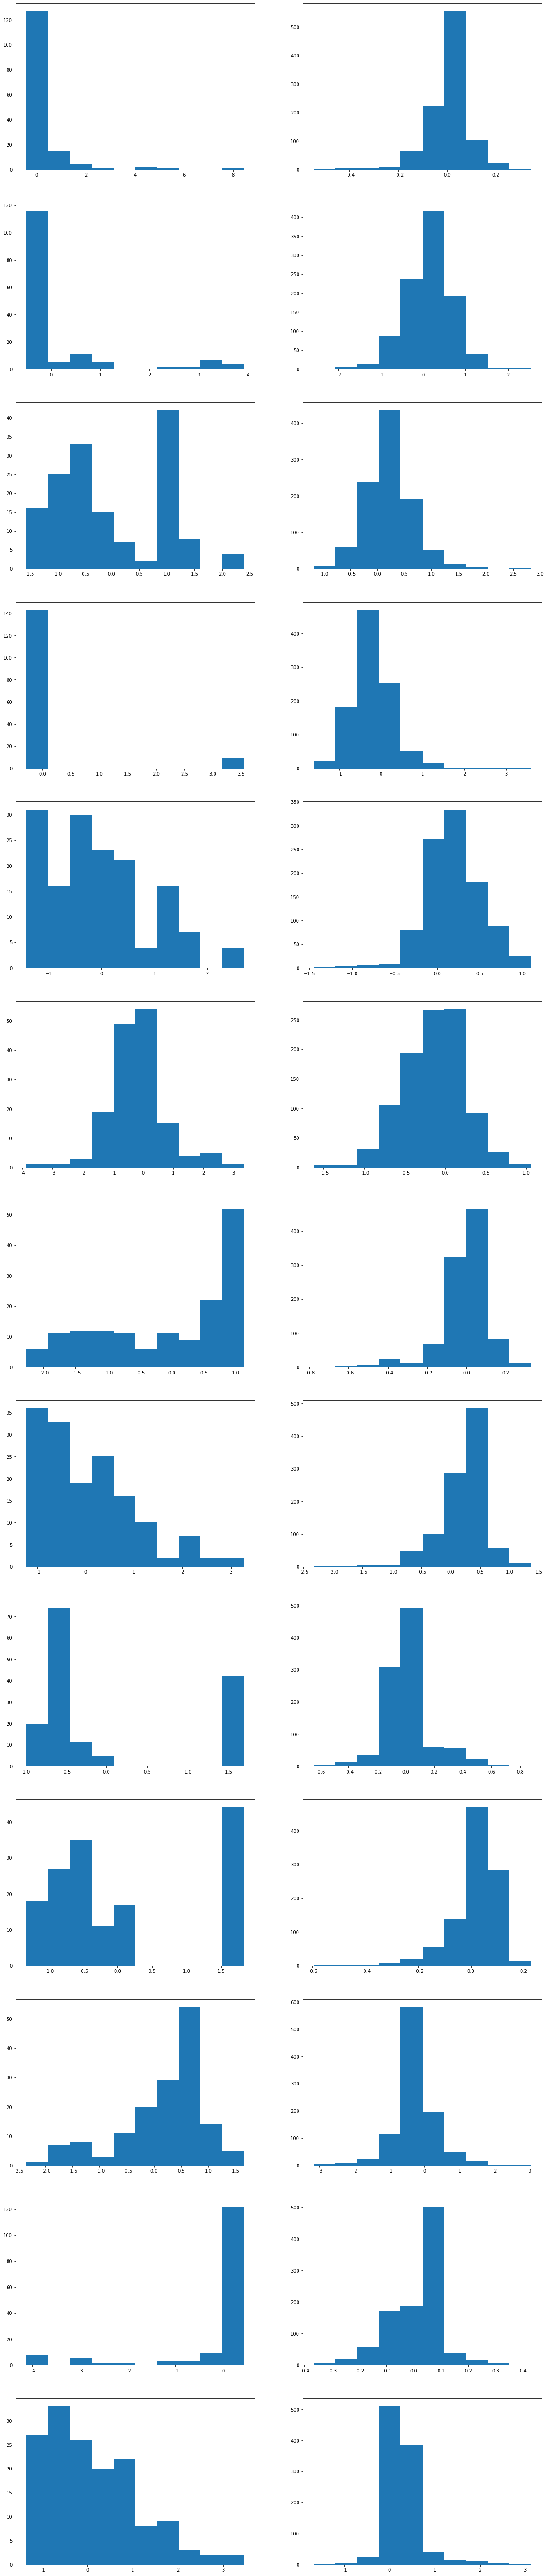

In [23]:
x_test = X_test.numpy()
x_samples = x_samples.detach().numpy()
figs, axs = plt.subplots(x_samples.shape[1], 2, figsize=(20, 100))
for i in range(x_samples.shape[1]):
    axs[i, 0].hist(x_test[:,i])
    axs[i, 1].hist(x_samples[:,i])
plt.show()

In [24]:
np.corrcoef(x_test, rowvar=False)[2]

array([ 0.42486438, -0.51290453,  1.        ,  0.03220062,  0.76409769,
       -0.35575224,  0.66757595, -0.72731343,  0.63361793,  0.7646962 ,
        0.45750608, -0.41160893,  0.66605524])

In [25]:
np.corrcoef(x_samples, rowvar=False)[2]

array([-0.15602941,  0.17624517,  1.        ,  0.12787115,  0.03505801,
       -0.10072295, -0.22147888,  0.14292427, -0.23887647,  0.14200879,
        0.29365768,  0.00790946,  0.20665021])

In [26]:
eps = torch.randn_like(std_x)
x_samples = mu_x + eps * torch.exp(std_x)
print(x_samples.shape)
print(X_test.shape)

torch.Size([1000, 13])
torch.Size([152, 13])


In [27]:
x_samples = x_samples.detach().numpy()
X_test = X_test.numpy()

In [28]:
# # for i in range(x_samples.shape[1]):
# figs, axs = plt.subplots(x_samples.shape[1], 2, figsize=(20, 100))
# # print(X_test[:,0].shape)
# # print(X_test[:,0].min())
# # print(X_test[:,0].max())
# # print(x_samples[:,0].min())
# # print(x_samples[:,0].max())
# for i in range(x_samples.shape[1]):
#     axs[i, 0].hist(X_test[:,i])
#     axs[i, 1].hist(x_samples[:,i])
# plt.show()

In [29]:
mu_x.mean(0)

tensor([ 0.0023,  0.1312,  0.2119, -0.2025,  0.1846, -0.1558, -0.0086,  0.2180,
         0.0072,  0.0165, -0.2725,  0.0074,  0.2731], dtype=torch.float64,
       grad_fn=<MeanBackward1>)

In [30]:
X_test.mean(0)

array([ 0.05758123, -0.00594503,  0.00179102, -0.05457096, -0.07319324,
       -0.19021743, -0.02709023,  0.04573705,  0.04304216,  0.02391869,
        0.26229687, -0.11611849,  0.10870962])

In [31]:
std_x.mean(0)

tensor([-0.0617,  0.2984,  0.2411,  0.2331,  0.1735,  0.1998,  0.0312, -0.1382,
         0.0158,  0.0019, -0.1407,  0.0043,  0.1077], dtype=torch.float64,
       grad_fn=<MeanBackward1>)

In [32]:
X_test.std(0)

array([1.11058185, 1.10298352, 0.96335937, 0.90474325, 0.9732048 ,
       0.90859733, 1.05820349, 0.96849369, 1.02646713, 1.04093606,
       0.83007593, 1.15621229, 1.01067781])

1. What are the 13 features 
2. What does plotting the histogram represent. 

In [33]:
np.corrcoef(X_test, rowvar=False)[0]

array([ 1.        , -0.1910687 ,  0.42486438, -0.08718963,  0.46821577,
       -0.23795259,  0.38613771, -0.40293044,  0.63190985,  0.58463217,
        0.27942462, -0.52906495,  0.55059428])

In [34]:
np.corrcoef(x_samples, rowvar=False)[0]

array([ 1.00000000e+00, -1.06280951e-02,  5.58131580e-03,  1.94175373e-03,
       -1.10710763e-02,  4.13825267e-03, -5.25730406e-03, -1.93388784e-02,
       -1.35591793e-02,  2.87339048e-04,  2.81092408e-02, -2.19838517e-02,
        2.12135752e-02])